In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import os
import time

from rsvd import rSVD, random_svd, truncated_svd
from visualization import svd_rsvd_error_time_analysis, plot_image_svd_reconstructions, plot_GD_vs_energy_saving_cutoff_selection

plt.rcParams['figure.figsize'] = [16,6]
plt.rcParams.update({'font.size': 12})

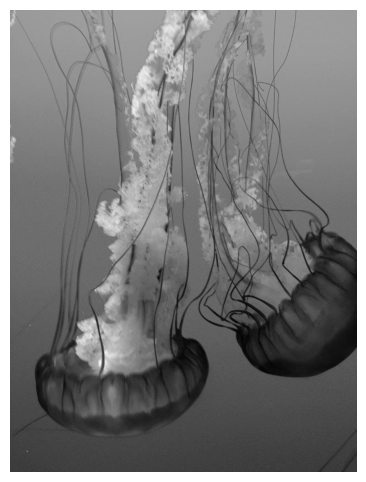

shape = (1024, 768)


In [2]:
exp_name = 'jelly.jpg'
A = imread(os.path.join('..', 'images', exp_name)) # Try your own image and play around with target rank
X = np.mean(A,axis=2) # Converts RGB -> grayscale

img = plt.imshow(X)
img.set_cmap('gray')
plt.axis('off')
plt.show()
print(f"shape = {X.shape}")

# Standard Image Reconstruction via SVD

In [3]:
U, s, VT = np.linalg.svd(X,full_matrices=False)
S = np.diag(s)

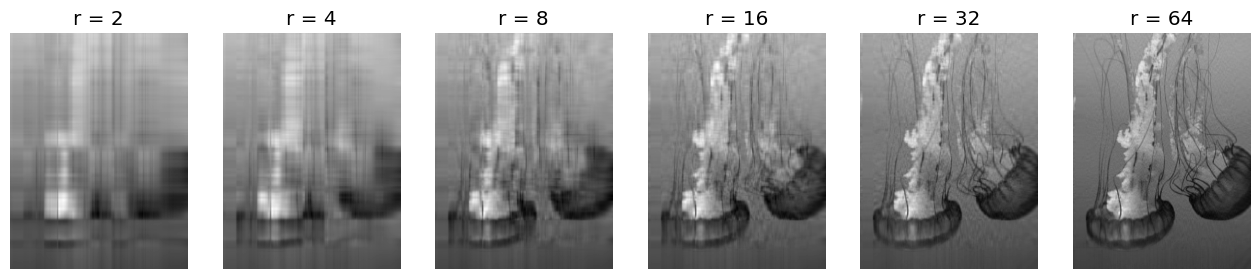

In [4]:
plot_image_svd_reconstructions(U, S, VT, [2**(k+1) for k in range(6)])

# Gavish-Donoho Threshold in Action

#### We'll compare the performance with a rule of thumb to cut off when cumulated sum of singular values reaches 90% of total sum. 

In [5]:
sigma_median=np.median(s)

# Computing the threshold value using Gavish-Donoho formula
beta=min(X.shape)/max(X.shape)
lda=0.56*beta**3 - 0.95*beta**2 + 1.82*beta + 1.43
threshold=lda*sigma_median

GD_cutoff_rank = np.max(np.where(s > threshold))

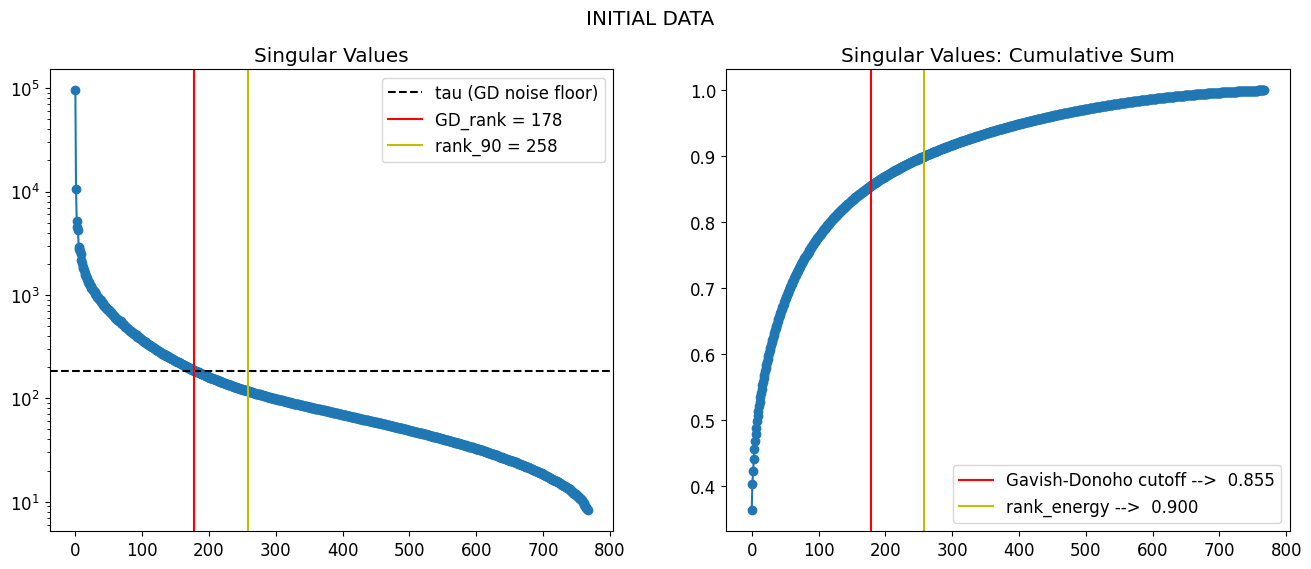

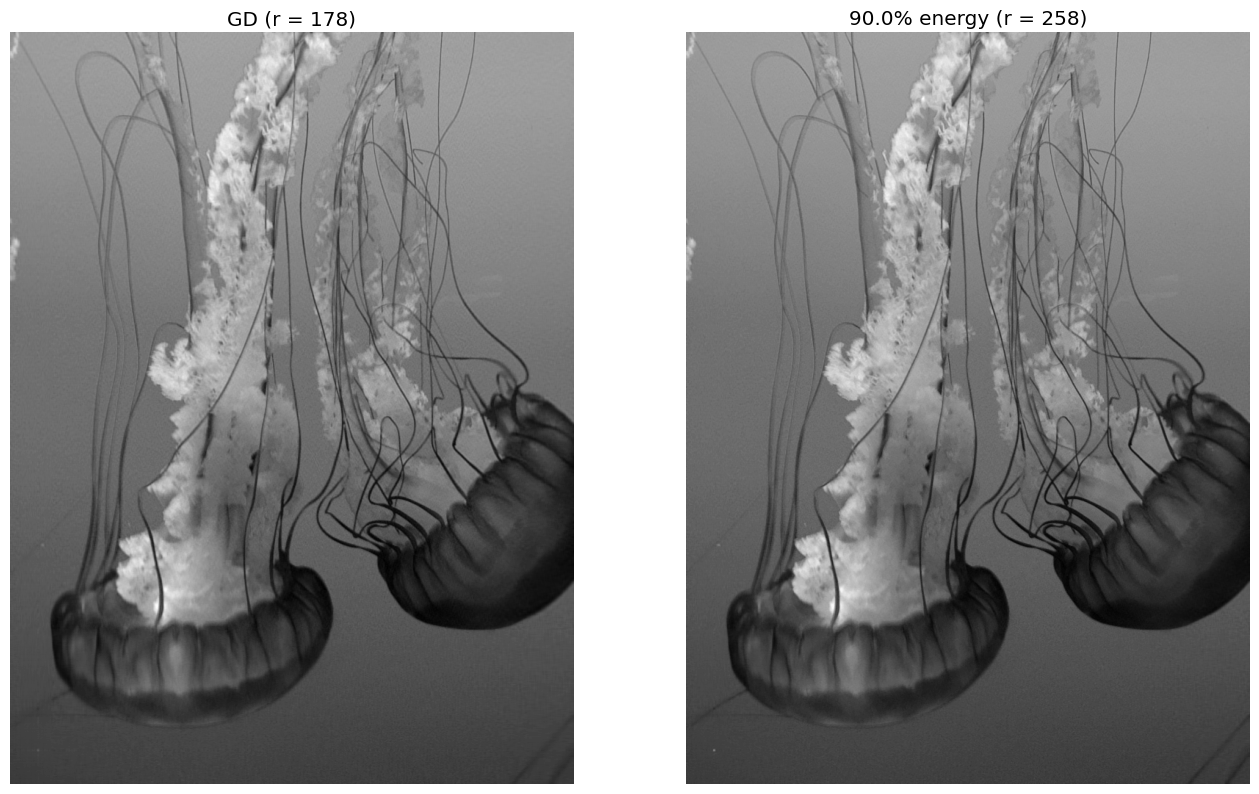

In [6]:
energy_frac = 0.9
rank_energy = plot_GD_vs_energy_saving_cutoff_selection(title="INITIAL DATA", 
                                          sigmas=s, 
                                          tau=threshold, 
                                          GD_rank=GD_cutoff_rank, 
                                          energy_frac=energy_frac)

plot_image_svd_reconstructions(U, S, VT, [GD_cutoff_rank, rank_energy], labels=["GD", f"{energy_frac*100:.1f}% energy"])

#### Doesn't look like it it does a lot of improvement, but let's use GD threshold for its original purpose - denoising.

# Gavish-Donoho vs Additive White Gaussian Noise

### Adding noise

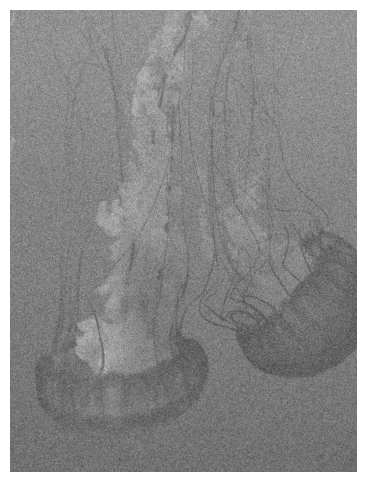

In [7]:
np.random.seed(420)
Noise = 0.5 * np.mean(X) * np.random.normal(0,1,X.shape)
X_noisy = X + Noise
img = plt.imshow(X_noisy)
img.set_cmap('gray')
plt.axis('off')
plt.show()

### Computing GD cutoff

In [8]:
U_noisy, s_noisy, Vt_noisy = np.linalg.svd(X_noisy,full_matrices=False)
S_noisy = np.diag(s_noisy)

sigma_median_noisy = np.median(s_noisy)
# Computing the threshold
threshold_noisy =lda*sigma_median_noisy

GD_cutoff_rank_noisy = np.max(np.where(s_noisy > threshold_noisy)) + 1

# Intuition behind GD threshold $\tau$

#### Gaussian matrix with same shape and 0 mean (since noise is white) produces always the same curve (up to multiplication with constant) of singular values. So we can cut off when the sigmas curve of the noisy image becomes indistinguishable from Gaussian sigmas curve.

#### To find proper constant (if magnitude of noise not given) we can assume that median(or any other quantile) sigma is already mostly caused by noisy part -> should be the same for Gaussian noise.  

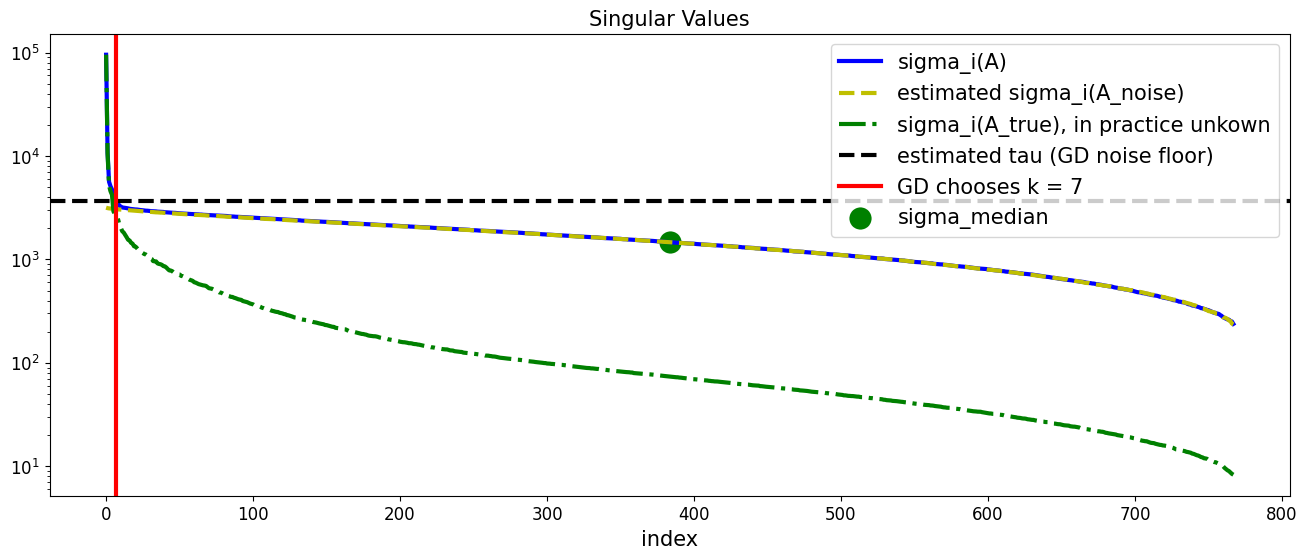

In [9]:
# align medians (kiss Gaussian sigmas curve with our sigmas curve and  at the midpoint)
unit_noise = np.random.normal(0, 1, X.shape)
s_unit_noise = np.linalg.svd(unit_noise, full_matrices=False)[1]
estimated_noise = s_unit_noise * (np.median(s_noisy) / np.median(s_unit_noise))


plt.figure(figsize=(16,6))
plt.semilogy(s_noisy, color='b',linewidth=3, label='sigma_i(A)')
plt.semilogy(estimated_noise, '--', color='y', linewidth=3, label='estimated sigma_i(A_noise)')

plt.semilogy(s, '-.', color='g', linewidth=3,label='sigma_i(A_true), in practice unkown')

plt.axhline(threshold_noisy, color='k', linestyle='--',linewidth=3, label=f"estimated tau (GD noise floor)")
plt.axvline(GD_cutoff_rank_noisy, color='r', linewidth=3, label=f"GD chooses k = {GD_cutoff_rank_noisy}")
plt.scatter(len(s_noisy) // 2, np.median(s_noisy), color='g', linewidths=10, label='sigma_median')


plt.title('Singular Values', fontsize=15)
plt.xlabel('index', fontsize=15)
plt.legend(fontsize=15)
plt.show()

### Comparison GD cutoff with standard 90% energy saving

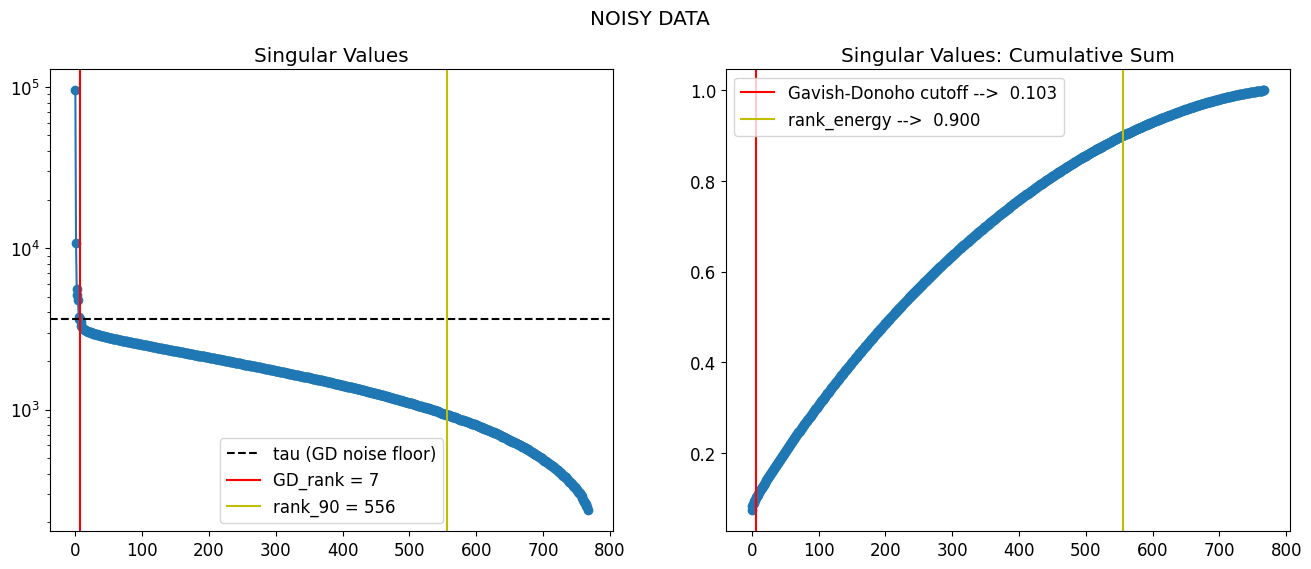

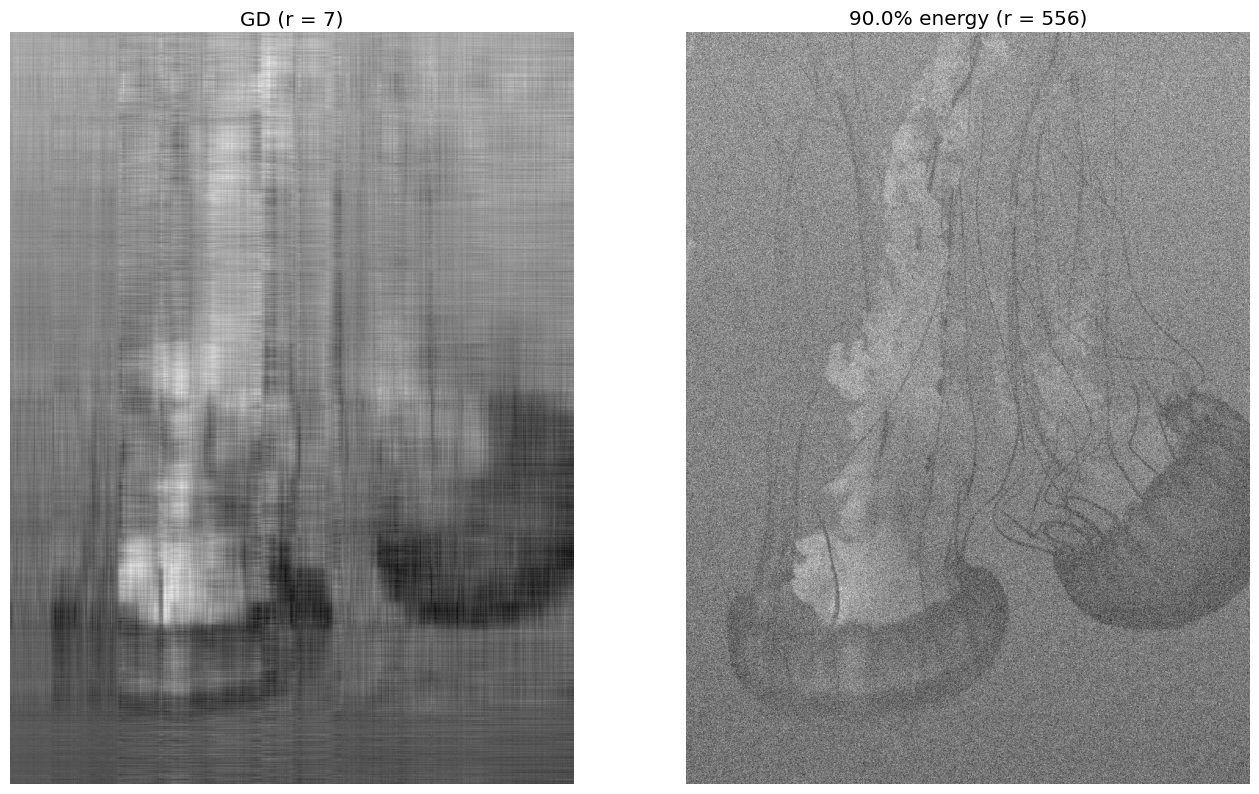

In [10]:
rank_energy_noisy = plot_GD_vs_energy_saving_cutoff_selection(title="NOISY DATA", 
                                          sigmas=s_noisy, 
                                          tau=threshold_noisy, 
                                          GD_rank=GD_cutoff_rank_noisy, 
                                          energy_frac=energy_frac)

plot_image_svd_reconstructions(U_noisy, S_noisy, Vt_noisy, [GD_cutoff_rank_noisy, rank_energy_noisy], labels=["GD", f"{energy_frac*100:.1f}% energy"])

#### The image with GD cutoff is blurry, but noise is clearly gone, but since we used median alignment with Gaussian sigma curve, we assume that the true rank is way smaller than half of full rank, which might lead to cutting off earlier than desired.

# Randomized vs Deterministic (aka Truncated) SVD
Let's explore using random projections to speed up SVD.

In [11]:
r = int(min(X.shape)*0.05) # Target rank
truncated_dict = truncated_svd(X, rank=r)
random_dict = random_svd(X, rank=r)

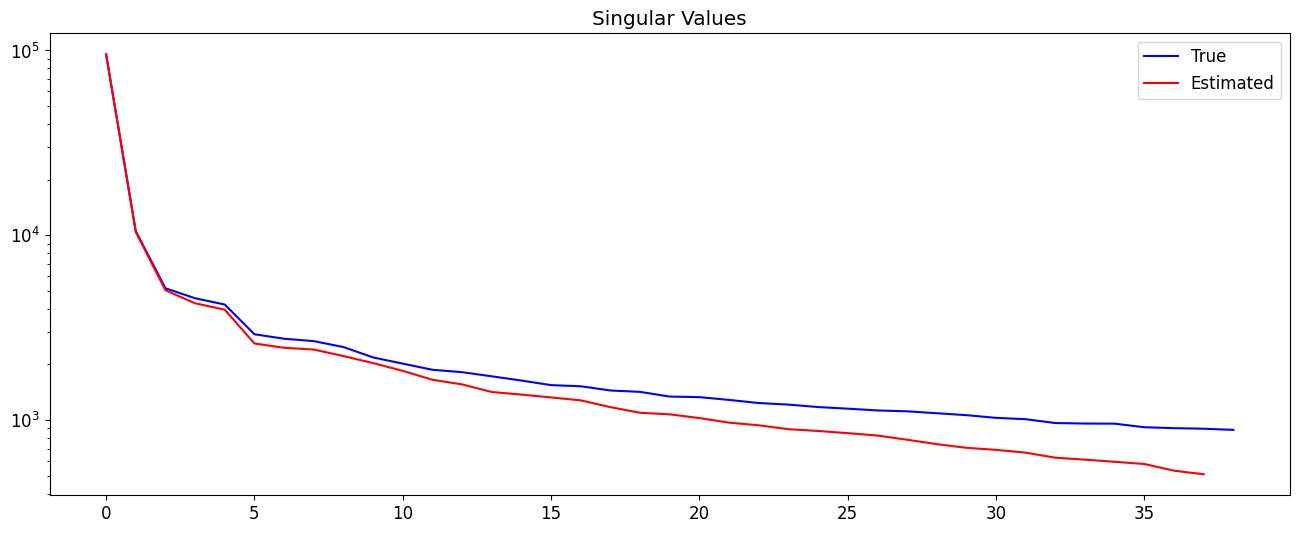

In [12]:
plt.yscale("log")
plt.plot(truncated_dict['sigmas'][:r+1], color='b', label='True')
plt.plot(random_dict['sigmas'][:r+1], color='r', label='Estimated')
plt.title("Singular Values")
plt.legend()
plt.show()

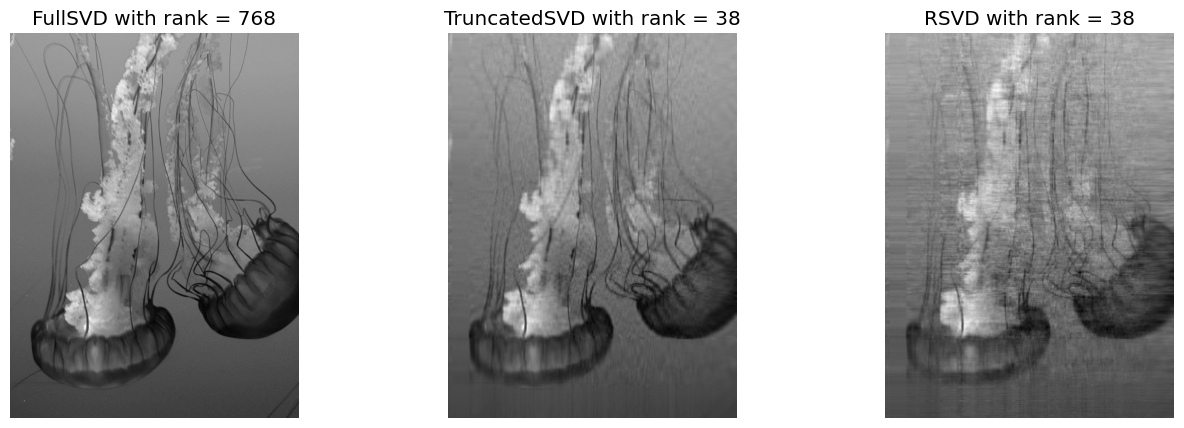

Trunceted SVD by truncating full SVD took  0.227 seconds
RSVD took  0.008 seconds
Truncated SVD relative error =  0.056
RSVD relative error =  0.083
Truncated is ~ 1.49 times better than RSVD error
Truncated is ~ 29.74 times slower than RSVD


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))
images = [X, truncated_dict['approximation'], random_dict['approximation']]
titles = [f"FullSVD with rank = {min(X.shape)}",
          f"TruncatedSVD with rank = {r}",
          f"RSVD with rank = {r}"]
for i in range(3):
    img = ax[i].imshow(images[i])
    img.set_cmap('gray')
    ax[i].axis('off')
    ax[i].set_title(titles[i])
plt.show()

print(f"Trunceted SVD by truncating full SVD took {truncated_dict['method_time']: .3f} seconds")
print(f"RSVD took {random_dict['method_time']: .3f} seconds")
print(f"Truncated SVD relative error = {truncated_dict['relative_error']: .3f}")
print(f"RSVD relative error = {random_dict['relative_error']: .3f}")
print(f"Truncated is ~{random_dict['relative_error'] / truncated_dict['relative_error']: .2f} times better than RSVD error")
print(f"Truncated is ~{truncated_dict['method_time'] / random_dict['method_time']: .2f} times slower than RSVD")

# Different variations of RSVD
#### Compare relative error $\frac{|| X - X_{approx}||_F}{||X||_F}$ and time required for computing approximation
#### p is oversampling parameter, the random projection matrix has (r + p) columns
#### q is number of power iterations, specifies how many times random projection matrix is applied, see rsvd.py for details.

In [14]:
all_rsvd_dict = dict()
all_truncated_dict = dict()

ranks = [3, 5, 10, 25, 50, 100, 250]
while ranks[-1] * 2 < min(X.shape):
    ranks.append(ranks[-1] * 2)
if (ranks[-1] - (min(X.shape) - 1))/ (min(X.shape) - 1) > 0.05:
    ranks.append(min(X.shape) - 1)

for q in [0, 1, 2]:
    all_rsvd_dict[q] = dict()
    for p in [0, 10]:
        all_rsvd_dict[q][p] = dict()
        for r in ranks:
            all_rsvd_dict[q][p][r] = random_svd(X, rank=r, p=p, q=q)


for r in ranks:
    all_truncated_dict[r] = truncated_svd(X, rank=r)


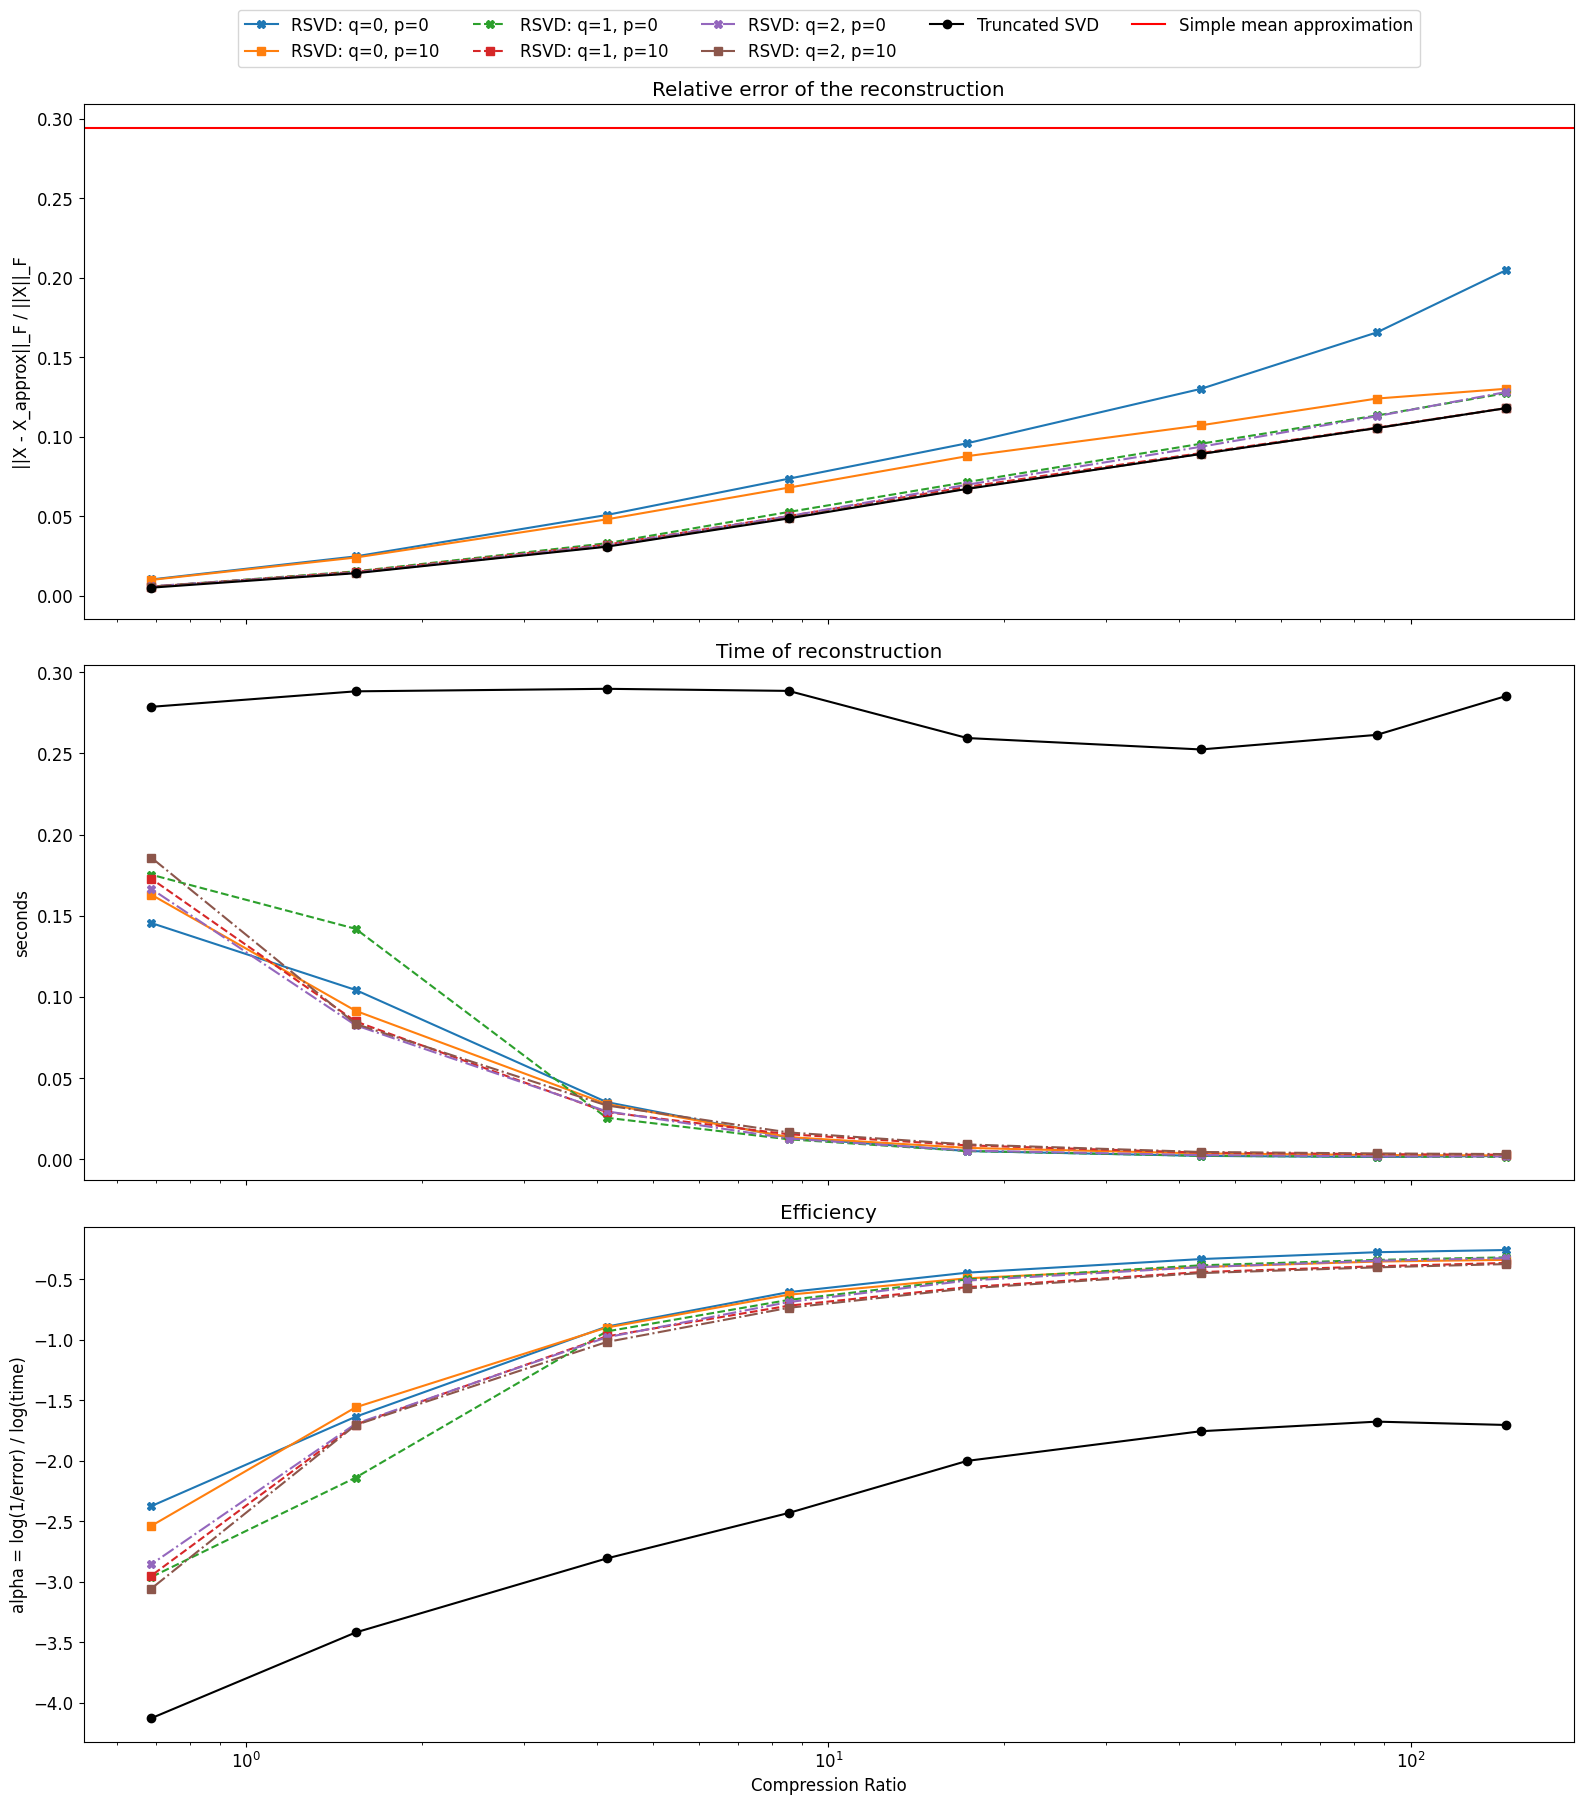

In [15]:
svd_rsvd_error_time_analysis(exp_name=exp_name.replace('.', '_'), X=X, all_rsvd_dict=all_rsvd_dict, truncated_svd_dict=all_truncated_dict)